# Test equation 1

$$
u' = -100 \cdot u + \cos(t)
$$
$$
u(0) = 0
$$

In [233]:
from rk_methods import *
from imex_methods import *
from measure import*
from order_estimate import *

def g(t, u):
    return -100 * u

G = [[-100]]

def f(t, u):
    return 1 * np.cos(t)

def f_exact(t):
    return 1/10001 * (-100 * np.exp(-100 * t) + np.sin(t) + 100 * np.cos(t))
    # return 1/10001 * (9001 * np.exp(-100 * t) + 10 * np.sin(t) + 1000 * np.cos(t))
    # return 1/10001 * ((-10*np.sin(0) - 1000*np.cos(0)) * np.exp(-100 * (t - 0)) + 10 * np.sin(t) + 1000 * np.cos(t))

Ns = list(range(10, 10001, 10))

Tl = 0
Tr = 5

### IMEX Euler

$$
    y_{n+1} = y_n + h ( f_1(t_n, y_n) + f_2(t_{n + 1}, y_{n+1}))
$$

In [ ]:
A = [[1]]
b = [1]
c = [1]
A_ = [[0, 0], [1, 0]]
b_ = [1, 0]

table = create_mesasurement(f, g, A, A_, b, b_, c, Tl, Tr, f_exact, [0.01, 0.005, 0.001], G, Ns, verbose=False)

from IPython.display import HTML, display
display(HTML(table))

Name,Exec time (s),Step Size,Error,Exec time (s),Step Size,Error,Exec time (s),Step Size,Error
ERK,0.00767,0.01786,0.00953,0.01184,0.0119,0.00495,0.02508,0.00435,0.001
IRK,0.00273,0.5,0.00022,0.00172,0.5,0.00022,0.1115,0.00704,0.001
IMEX,0.00268,0.5,0.00494,0.00196,0.5,0.00494,0.06309,0.00704,0.001
IMEX Lin,0.00116,0.5,0.00494,0.00107,0.5,0.00494,0.03986,0.00704,0.001
IMEX LU,0.00116,0.5,0.00494,0.00109,0.5,0.00494,0.06296,0.00704,0.001


In [ ]:
IMEX_E_order_result = order_from_fine_grid(lambda y0, Tl, Tr, N: IMEX(f, LinearImplicitSolver(G), y0, A, A_, b, b_, c, Tl, Tr, N), f_exact(0), Tl, Tr, [2**11, 2**12, 2**13], 2**16)
print('Estimating order from fine grid:')
print(f'Order result: {IMEX_E_order_result}')

Estimating order from fine grid:
Order result: [0.98008702 1.06339737]


### IMEX trapezoid

$$
y_{n+1} = y_n + \tfrac{h}{2} (f(t_n, y_n) + f_1(t_{n+1}, y_n + h \cdot f(t_n, y_n)) + f_2(t_{n+1}, y_{n+1}))
$$

In [236]:
from imex_methods import *

h, t, y = IMEX_trapezoid(f, g, f_exact(0), Tl, Tr, 8000)

error = np.linalg.norm(y - f_exact(t), np.inf)

IMEX_trapezoid_order_result = order_from_fine_grid(lambda y0, Tl, Tr, N: IMEX_trapezoid(f, g, y0, Tl, Tr, N), f_exact(0), Tl, Tr, [2**11, 2**12, 2**13], 2**15)
print('Estimating order from fine grid:')
print(f'Order result: {IMEX_trapezoid_order_result}')

Estimating order from fine grid:
Order result: [2.02417039 2.07215471]


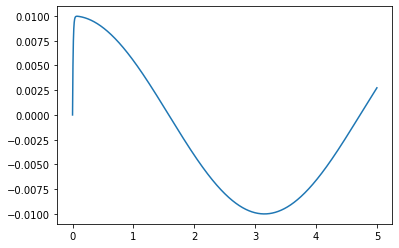

In [237]:
import matplotlib.pyplot as plt

plt.plot(t, y)

### IMEX midpoint

In [238]:
A = [[1/2]]
b = [1]
c = [1/2]
A_ = [[0, 0], [1/2, 0]]
b_ = [0, 1]

table = create_mesasurement(f, g, A, A_, b, b_, c, Tl, Tr, f_exact, [0.01, 0.005, 0.001], G, Ns, verbose=False)

from IPython.display import HTML, display
display(HTML(table))

Name,Exec time (s),Step Size,Error,Exec time (s),Step Size,Error,Exec time (s),Step Size,Error
ERK,0.1431,0.01923,0.00836,0.03987,0.01613,0.00489,0.01405,0.00893,0.00096
IRK,0.00396,0.5,0.00981,0.03012,0.05556,0.00475,0.04732,0.01667,0.00098
IMEX,0.00541,0.16667,0.00832,0.03595,0.05556,0.00473,0.02977,0.01667,0.00098
IMEX Lin,0.00368,0.16667,0.00832,0.02578,0.05556,0.00473,0.0191,0.01667,0.00098
IMEX LU,0.00368,0.16667,0.00832,0.01008,0.05556,0.00473,0.03448,0.01667,0.00098


In [239]:
IMEX_midpoint_order_result = order_from_fine_grid(lambda y0, Tl, Tr, N: IMEX(f, LinearImplicitSolver(G), y0, A, A_, b, b_, c, Tl, Tr, N), f_exact(0), Tl, Tr, [2**11, 2**12, 2**13], 2**15)
print('Estimating order from fine grid:')
print(f'Order result: {IMEX_trapezoid_order_result}')

Estimating order from fine grid:
Order result: [2.02417039 2.07215471]


### IMEX3

In [240]:
gamma = (3 + np.sqrt(3)) / 6

A = [[gamma, 0], [1 - 2 * gamma, gamma]]
b = [1/2, 1/2]
c = [gamma, 1 - gamma]
A_ = [[0, 0, 0], [gamma, 0, 0], [gamma - 1, 2*(1 - gamma), 0]]
b_ = [0, 1/2, 1/2]

table = create_mesasurement(f, g, A, A_, b, b_, c, Tl, Tr, f_exact, [0.01, 0.005, 0.001], G, Ns, verbose=False)

from IPython.display import HTML, display
display(HTML(table))

Name,Exec time (s),Step Size,Error,Exec time (s),Step Size,Error,Exec time (s),Step Size,Error
ERK,0.01418,0.02381,0.00889,0.00816,0.02,0.00469,0.01555,0.01316,0.00098
IRK,0.00408,0.5,0.00711,0.01887,0.1,0.00492,0.06441,0.02174,0.001
IMEX,0.00699,0.16667,0.0055,0.01038,0.1,0.00486,0.04384,0.02174,0.001
IMEX Lin,0.00417,0.16667,0.0055,0.00781,0.1,0.00486,0.02612,0.02174,0.001
IMEX LU,0.00675,0.16667,0.0055,0.00939,0.1,0.00486,0.08994,0.02174,0.001


In [241]:
IMEX_3_order_result = order_from_fine_grid(lambda y0, Tl, Tr, N: IMEX(f, LinearImplicitSolver(G), y0, A, A_, b, b_, c, Tl, Tr, N), f_exact(0), 0, 20, [2**14, 2**15, 2**16], 2**18)
print('Estimating order from fine grid:')
print(f'Order result: {IMEX_3_order_result}')

Estimating order from fine grid:
Order result: [2.91602294 2.97434195]


# Test equation 2

$$
u' = -1000 \cdot u + \cos(t)
$$
$$
u(0) = 0
$$

In [242]:
from rk_methods import *
from imex_methods import *
from measure import*
from order_estimate import *

def g(t, u):
    return -1000 * u

G = [[-1000]]

def f(t, u):
    return 1 * np.cos(t)

def f_exact(t):
    return 1/1000001 * (-1000 * np.exp(-1000 * t) + 1 * np.sin(t) + 1000 * np.cos(t))

Ns = list([16, 260, 8200])

Tl = 0
Tr = 20

### IMEX 3

In [243]:
gamma = (3 + np.sqrt(3)) / 6

A = [[gamma, 0], [1 - 2 * gamma, gamma]]
b = [1/2, 1/2]
c = [gamma, 1 - gamma]
A_ = [[0, 0, 0], [gamma, 0, 0], [gamma - 1, 2*(1 - gamma), 0]]
b_ = [0, 1/2, 1/2]

table = create_mesasurement(f, g, A, A_, b, b_, c, Tl, Tr, f_exact, [0.001], G, Ns, verbose=False)

from IPython.display import HTML, display
display(HTML(table))

/tmp/ipykernel_28471/2293068865.py:7: RuntimeWarning: overflow encountered in multiply
  return -1000 * u


Name,Exec time (s),Step Size,Error
ERK,0.7362,0.00244,0.00097
IRK,0.00869,1.25,0.0009
IMEX,0.0812,0.07692,0.00097
IMEX Lin,0.03738,0.07692,0.00097
IMEX LU,0.0594,0.07692,0.00097
